In [1]:
from skimage import io
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)

In [4]:
NEIGHBOR_SCALE_FACTOR = 10  # the bigger this value, the lesser the weights of neighbours are updated

In [5]:
LR_DECAY = 5  # the bigger this value, the slower the learning rate decays

In [6]:
# lattice dimensions: M x M
M = 3

In [7]:
def euclidean(x, w):
    """
    Returns euclidean distance.
    For computation efficiency, square root is not done.
    
    """
    n = len(x)
    dist = 0
    for i in range(n):
        dist += (x[i] - w[i]) ** 2
    return dist

In [8]:
X = np.random.randint(low=0, high=255, size=(1000, 3))

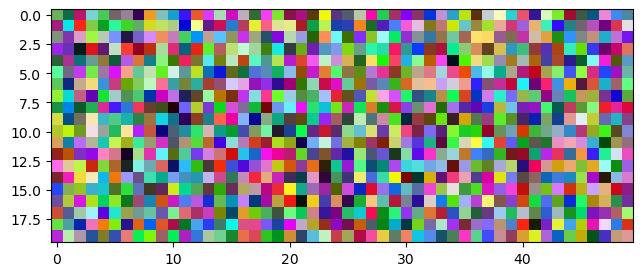

In [9]:
io.imshow(np.uint8(X.reshape(20, len(X)//20, 3)))

In [10]:
X = X / 255  # scale values

In [11]:
W = np.random.randint(low=0, high=255, size=(9, 3))

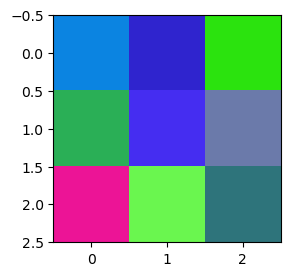

In [12]:
# initialized lattice wihth random weights
plt.figure(figsize=(3, 3))
io.imshow(np.uint8(W.reshape(3, 3, 3)))

In [13]:
W = W / 255

In [14]:
W

array([[0.04313725, 0.51764706, 0.88235294],
       [0.18431373, 0.14117647, 0.80784314],
       [0.16862745, 0.89019608, 0.05490196],
       [0.16470588, 0.68627451, 0.3372549 ],
       [0.27058824, 0.17647059, 0.94509804],
       [0.41960784, 0.47843137, 0.66666667],
       [0.9254902 , 0.07843137, 0.58823529],
       [0.41568627, 0.96470588, 0.30980392],
       [0.18039216, 0.45490196, 0.48235294]])

In [15]:
def find_neighbourhood_radius(step):
    """
    Returns the radius that is considered the neigbourhood.
    It decreases with each step/iteration.
    
    """
    return M - step

In [16]:
def find_bmu(x):
    """
    Find the best matching unit by computing euclidean distance
    and then return its index.
    
    """
    distances = [euclidean(w, x) for w in W]
    closest_node = pd.Series(distances).idxmin()
    return closest_node

In [17]:
def update_wt(i, x, lr, scale=1):
    """
    Update the weight at index i based on input x.
    The weight can belong to the BMU node or one of its neighbours.
    For the neighbours, we use scale to update their weights based on 
    how far/close they are to BMU.
    
    """
    lr /= scale   # if neighbours are far we'd update their weights weakly
    w_updated = (W[i] + (lr * (x - W[i])))
    W[i] = w_updated

In [18]:
# for simplicity it's precomputed which nodes are within the neighbourhood for 
# each radius of each node as a BMU, alongwith how close they are.
# for example, for radius 3 node 0 (as BMU) has node 1 in the neighbourhood at 
# distance 1 and node 8 in the neigbourhood at distance 2.
# similarly, for radius 2 node 0 (as BMU) has node 1 in the neighbourhood at 
# distance 1 but node 8 is not in the neigbourhood anymore.
neigbourhood_dist_map = {
    3: {
        0: [(1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 2), (7, 2), (8, 2)],
        1: [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 2)],
        2: [(0, 2), (1, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 2), (8, 2)],
        3: [(0, 1), (1, 1), (2, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2)],
        4: [(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
        5: [(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (6, 2), (7, 1), (8, 1)],
        6: [(0, 2), (1, 2), (2, 2), (3, 1), (4, 1), (5, 2), (7, 1), (8, 2)],
        7: [(0, 2), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (8, 1)],
        8: [(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1)],
    },
    2: {
        0: [(1, 1), (3, 1), (4, 1)],
        1: [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
        2: [(1, 1), (4, 1), (5, 1)],
        3: [(0, 1), (1, 1), (4, 1), (6, 1), (7, 1)],
        4: [(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
        5: [(1, 1), (2, 1), (4, 1), (7, 1), (8, 1)],
        6: [(3, 1), (4, 1), (7, 1)],
        7: [(3, 1), (4, 1), (5, 1), (6, 1), (8, 1)],
        8: [(4, 1), (5, 1), (7, 1)]
    }
}

In [19]:
def update_neighbourhood_wts(radius, x, bmu_idx, lr):
    """
    For BMU we update the weights of its neighbours within given
    radius.
    
    """
    if radius == 1:  # bmu has no neighbours
        return
    neigbours = neigbourhood_dist_map[radius][bmu_idx]
    for j, dist in neigbours:  # node at index j is a neighbour at distance dist
        update_wt(j, x, lr, dist * NEIGHBOR_SCALE_FACTOR)

  0%|          | 0/3 [00:00<?, ?it/s]

[0/3]:
learning rate: 0.5


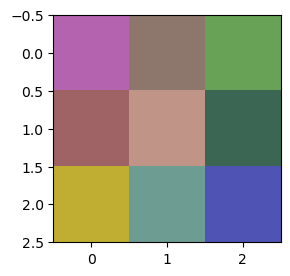

 33%|███▎      | 1/3 [00:00<00:00,  3.60it/s]

[1/3]:
learning rate: 0.4093653765389909


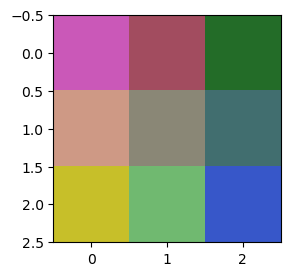

 67%|██████▋   | 2/3 [00:00<00:00,  3.90it/s]

[2/3]:
learning rate: 0.2744058180470132


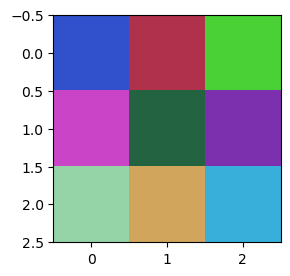

100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


In [20]:
lr = 0.5  # learning rate
no_of_epochs = 3

# training
for epoch in tqdm(range(no_of_epochs)):
    lr = lr * np.exp(-epoch / 5)  # exponentially decay the learning rate
    for x in X:
        bmu_idx = find_bmu(x)
        update_wt(bmu_idx, x, lr)  # update weight of bmu
        update_neighbourhood_wts(find_neighbourhood_radius(epoch), x, bmu_idx, lr)  # update neighbourhood weights
    print(f"[{epoch}/{no_of_epochs}]:")
    print(f"learning rate: {lr}")
    _W = W * 255
    plt.figure(figsize=(3, 3))
    io.imshow(np.uint8(_W.reshape(3, 3, 3)))
    plt.show()

In [21]:
W

array([[0.19605144, 0.314093  , 0.79781748],
       [0.69175651, 0.19554462, 0.29511884],
       [0.28822626, 0.82166184, 0.21398881],
       [0.79546632, 0.26781963, 0.78729553],
       [0.14087631, 0.39119698, 0.26081086],
       [0.49394394, 0.18983355, 0.68000121],
       [0.58162156, 0.83314085, 0.65367297],
       [0.8222953 , 0.64972292, 0.36366554],
       [0.22059098, 0.6882557 , 0.85609524]])

In [22]:
W = W * 255

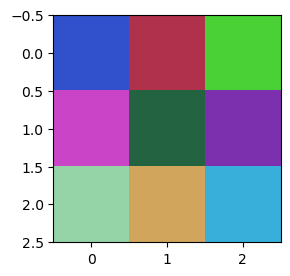

In [23]:
# final lattice
plt.figure(figsize=(3, 3))
io.imshow(np.uint8(W.reshape(3, 3, 3)))

![red](red_test.png)

In [24]:
x_test = [204, 0, 0]  # shade of red

In [25]:
find_bmu(x_test)  # the node at index 1 in our final lattice above has dark red shade :)

1

![green](green_test.png)

In [26]:
x_test = [0, 153, 0]  # shade of green

In [27]:
find_bmu(x_test)   # the node at index 4 in our final lattice above has dark green shade :)

4

![blue](blue_test.png)

In [28]:
x_test = [102, 178, 255]  # shade of blue

In [29]:
find_bmu(x_test) # the node at index 8 in our final lattice above has bright blue shade :)

8